## Project imports

In [20]:
from keras.layers import Flatten, Input, Rescaling
from keras.layers import Conv2D, MaxPooling2D, Dense
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import image_dataset_from_directory
from matplotlib import pyplot as plt
import os
import shutil

## Prepare the dataset

In [8]:
original = 'DataSet'
dataset = 'data'
def make_subset(subset, start_index, end_index):
    for category in ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']:
        path_name = f'{dataset}/{subset}/{category}'
        os.makedirs(path_name)
        file_names = [f'{category}-{i}.png' for i in range(start_index, end_index)]
        for file_name in file_names:
            shutil.copyfile(src=f'{original}/{category}/{file_name}', dst=f'{path_name}/{file_name}')

make_subset('train', 1, 1000)
make_subset('validation', 1000, 1100)
make_subset('test', 1100, 1300)

## load the data into data loaders

In [10]:
train_data = image_dataset_from_directory(
    directory='data/train/',
    batch_size=32,
    image_size=(180, 180)
)

val_data = image_dataset_from_directory(
    directory='data/validation/',
    batch_size=32,
    image_size=(180, 180)
)

test_data = image_dataset_from_directory(
    directory='data/test/',
    batch_size=32,
    image_size=(180, 180)
)

Found 3996 files belonging to 4 classes.
Found 400 files belonging to 4 classes.
Found 800 files belonging to 4 classes.


## define the model

In [17]:
inputs = Input(shape=(180, 180, 3))
x = Rescaling(scale=1/255)(inputs)
x = Conv2D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_uniform')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu', kernel_initializer='he_uniform')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation='relu', kernel_initializer='he_uniform')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation='relu', kernel_initializer='he_uniform')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Flatten()(x)
x = Dense(units=10, activation='relu')(x)
outputs = Dense(4, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                      

## train the model

In [18]:
callbacks = [
    ModelCheckpoint(
        filepath='medical_model.keras',
        save_best_only=True,
    ),

    EarlyStopping(
        patience=3
    )
]

history = model.fit(train_data, epochs=5, validation_data=val_data, callbacks=callbacks)

Epoch 1/5
125/125 [==============================] - 253s 2s/step - loss: 1.2820 - accuracy: 0.5120 - val_loss: 0.8570 - val_accuracy: 0.5725
Epoch 2/5
125/125 [==============================] - 203s 2s/step - loss: 0.8286 - accuracy: 0.6471 - val_loss: 0.7415 - val_accuracy: 0.6175
Epoch 3/5
125/125 [==============================] - 197s 2s/step - loss: 0.6398 - accuracy: 0.7120 - val_loss: 0.7048 - val_accuracy: 0.7175
Epoch 4/5
125/125 [==============================] - 209s 2s/step - loss: 0.5640 - accuracy: 0.7880 - val_loss: 0.5921 - val_accuracy: 0.7275
Epoch 5/5
125/125 [==============================] - 222s 2s/step - loss: 0.4875 - accuracy: 0.8373 - val_loss: 0.6989 - val_accuracy: 0.7750


## plot model metrics

### loss

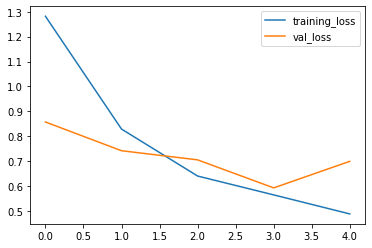

In [22]:
plt.figure()
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### accuracy

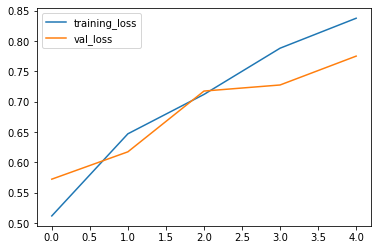

In [25]:
plt.figure()
plt.plot(history.history['accuracy'], label='training_loss')
plt.plot(history.history['val_accuracy'], label='val_loss')
plt.legend()

In [26]:
## Evaluate the model

In [27]:
test_loss, test_acc = load_model('medical_model.keras').evaluate(test_data)

25/25 [==============================] - 13s 462ms/step - loss: 0.4967 - accuracy: 0.8075
